<a href="https://colab.research.google.com/github/Clauberthoz/Clauberthoz/blob/main/Projeto_Moda_Fitness_LM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Project Description**

**Claubeth Oliveira Zimmermann**

Model Fitness, a gym chain, is developing a customer interaction strategy based on data analytics.

One of the most common challenges gyms and other service businesses face is customer churn. How do you know if a customer is no longer with you? You can calculate churn based on customers who cancel their memberships or fail to renew their contracts. However, sometimes it’s not immediately obvious that a customer has left.

For a gym, it makes sense to consider a customer as "churned" if they haven’t visited in a month. Typically, if a customer signs up, attends a few times, and then disappears, they’re unlikely to return.

Instead of struggling with churn, Model Fitness has digitized a portion of customer profiles. The task is to analyze them and develop a customer retention strategy.

###**Objectives:**

####Predict churn probability (for the next month) for each customer.

####Create user personas: Identify the most distinct customer groups and describe their key characteristics.

####Analyze the factors that most impact churn.

####Draw key conclusions and develop recommendations for improving customer service:

####Identify target groups for retention efforts.

####Suggest measures to reduce churn.

####Highlight any other patterns in customer interactions.

###**Data Description**

####**Target Variable:**

Churn – Whether the customer churned in the given month.

Customer Attributes (from the previous month):

gender – Gender of the customer.

Near_Location – Whether the customer lives or works near the gym.

Partner – Whether the user is an employee of a partner company (the gym has corporate partnerships offering discounts).

Promo_friends – Whether the customer signed up through a "bring a friend" promotion (they typically used a friend’s referral code at signup).

Phone – Whether the user provided their phone number.

age – Customer age.

Lifetime – Time (in months) since the customer’s first visit.

Membership & Visit Data:

Contract_period – Membership duration (1 month, 6 months, or 12 months).

Month_to_end_contract – Months remaining until contract expiration.

Group_visits – Whether the customer attends group sessions.

Avg_class_frequency_total – Average weekly visits over the customer’s lifetime.

Avg_class_frequency_current_month – Average weekly visits in the current month.

Avg_additional_charges_total – Total money spent on other gym services (café, sports gear, cosmetics, massages, etc.).

**Would you like any refinements, such as:**

A more technical version for a data science audience?

A summary for business stakeholders?

Specific terms adjusted for industry standards?



## **First view and data cleaning**

In [1]:
# Importe as bibliotecas necessárias
import pandas as pd               # Para manipulação de dados em formato tabular
import numpy as np                # Para cálculos numéricos
import datetime as dt             # Para lidar com datas e horários
from itertools import chain      # Para manipulação de iterações
from scipy import stats as st    # Para cálculos estatísticos

# Defina o nível de significância
alpha = 0.05

# Importe bibliotecas de plotagem
import matplotlib as plot
import matplotlib.pyplot as plt  # Para criar gráficos
import seaborn as sns            # Para visualização de dados mais atraente

# Importe bibliotecas de aprendizado de máquina
from sklearn.model_selection import train_test_split     # Para dividir dados em conjuntos de treinamento e teste
from sklearn.preprocessing import StandardScaler        # Para padronização de dados
from sklearn.linear_model import LogisticRegression      # Para modelos de regressão logística
from sklearn.ensemble import RandomForestClassifier      # Para modelos de classificação com Random Forest
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score  # Métricas de avaliação de modelos

# Importe bibliotecas estatísticas
from statsmodels.stats.proportion import proportions_ztest  # Para testes de proporção
from scipy.cluster.hierarchy import dendrogram, linkage     # Para hierarquia de clusters
from sklearn.cluster import KMeans                          # Para algoritmo de agrupamento K-Means

# Suprima avisos
import warnings
warnings.filterwarnings('ignore')

## **First view and data cleaning**


In [2]:
try:
    # Tenta carregar o arquivo CSV de uma localização específica
    gym_churn = pd.read_csv('/gym_churn_us.csv')
except FileNotFoundError:
    # Se o arquivo não for encontrado na primeira localização, tenta a segunda
    try:
        gym_churn = pd.read_csv('/gym_churn_us.csv')
    except FileNotFoundError:
        print("O arquivo CSV não foi encontrado em nenhuma das localizações especificadas.")

In [3]:
display(gym_churn.info(memory_usage = 'deep'))

display(gym_churn.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

None

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


There are no missing values.




In [4]:
# Convert all columns in a DataFrame to lowercase
gym_churn.columns = gym_churn.columns.str.lower()

# Creates a new DataFrame 'gym_churn_avg' with only the specified columns
gym_churn_avg = gym_churn[['month_to_end_contract', 'avg_additional_charges_total', 'avg_class_frequency_total',
                           'avg_class_frequency_current_month']]

# Creates a new DataFrame 'gym_churn_uni' excluding the specified columns
gym_churn_uni = gym_churn.drop(['month_to_end_contract', 'avg_additional_charges_total',
                                'avg_class_frequency_total', 'avg_class_frequency_current_month'], axis=1)

# Display descriptive statistics for the DataFrame 'gym_churn_uni'
display(gym_churn_uni.describe())

# Display descriptive statistics for the DataFrame 'gym_churn_avg'
display(gym_churn_avg.describe())

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,lifetime,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,3.724750,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,3.749267,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,1.000000,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,3.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,5.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,31.000000,1.000000


,month_to_end_contract,avg_additional_charges_total,avg_class_frequency_total,avg_class_frequency_current_month
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,4.322750,146.943728,1.879020,1.767052
std,4.191297,96.355602,0.972245,1.052906
min,1.000000,0.148205,0.000000,0.000000
25%,1.000000,68.868830,1.180875,0.963003
50%,1.000000,136.220159,1.832768,1.719574
75%,6.000000,210.949625,2.536078,2.510336
max,12.000000,552.590740,6.023668,6.146783


In [5]:
gym_churn.duplicated().value_counts()

,count
False,4000


- There are no outliers or duplicates.
- The dataframe is ready for analysis.

## **Analysis**

### **Viewing the graph**

Creation of graphs by replacing absolute values ​​with percentages in order to abstract a better analysis of the plotted graphs.

In [6]:
def load_data(file_path):
    """Loads data from a CSV file"""
    return pd.read_csv(file_path)

def plot_categorical_churn(df, categorical_vars, figsize=(15, 10)):
    """Plots bar charts showing churn percentage by categorical variable"""
    plt.figure(figsize=figsize)
    plt.suptitle('Churn Distribution by Categorical Variables (in %)', y=1.02)

    for i, var in enumerate(categorical_vars, 1):
        plt.subplot(2, 3, i)
        cross_tab = pd.crosstab(df[var], df['Churn'], normalize='index') * 100
        sns.barplot(x=cross_tab.index, y=cross_tab[1], color='skyblue')

        plt.title(f'Churn by {var}')
        plt.xlabel(var)
        plt.ylabel('Churn Percentage (%)')
        plt.ylim(0, 100)

        for index, value in enumerate(cross_tab[1]):
            plt.text(index, value + 1, f'{value:.1f}%', ha='center')

    plt.tight_layout()
    plt.show()

def plot_contract_period_churn(df, figsize=(10, 6)):
    """Plots churn by contract duration"""
    plt.figure(figsize=figsize)
    cross_tab = pd.crosstab(df['Contract_period'], df['Churn'], normalize='index') * 100
    sns.barplot(x=cross_tab.index, y=cross_tab[1], color='salmon')

    plt.title('Churn by Contract Duration (in %)')
    plt.xlabel('Contract Duration (months)')
    plt.ylabel('Churn Percentage (%)')
    plt.ylim(0, 100)

    for index, value in enumerate(cross_tab[1]):
        plt.text(index, value + 1, f'{value:.1f}%', ha='center')

    plt.tight_layout()
    plt.show()

def plot_age_distribution(df, figsize=(10, 6)):
    """Plots age distribution by churn status"""
    plt.figure(figsize=figsize)
    sns.boxplot(x='Churn', y='Age', data=df)
    plt.title('Age Distribution by Churn Status')
    plt.xlabel('Churn')
    plt.ylabel('Age')
    plt.xticks([0, 1], ['No Churn', 'Churn'])
    plt.show()

def plot_correlation_matrix(df, corr_matrix, figsize=(11, 11)):
    """Plots correlation matrix between numerical variables"""
    plt.figure(figsize=figsize)
    # The following line was causing the error. 'df' does not have an attribute 'gym_churn'
    # df = analyze_churn_data(file_path='/gym_churn_us.csv')
    # corr_matrix = df.gym_churn.corr()
    # Instead, use the 'df' that's passed as an argument to the function:
    corr_matrix = df.corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
    plt.title('Correlation Matrix Between Numerical Variables and Churn')
    plt.tight_layout()
    plt.show()

def analyze_churn_data(file_path):
    """Main function that executes the entire analysis"""
    # Load data
    df = load_data(file_path)

    # Define variables for analysis
    categorical_vars = ['gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone', 'Group_visits']
    numeric_vars = ['Age', 'Avg_additional_charges_total', 'Month_to_end_contract',
                   'Lifetime', 'Avg_class_frequency_total', 'Avg_class_frequency_current_month']

    return df

# Example usage
if __name__ == "__main__":
    df = analyze_churn_data(file_path='/gym_churn_us.csv')

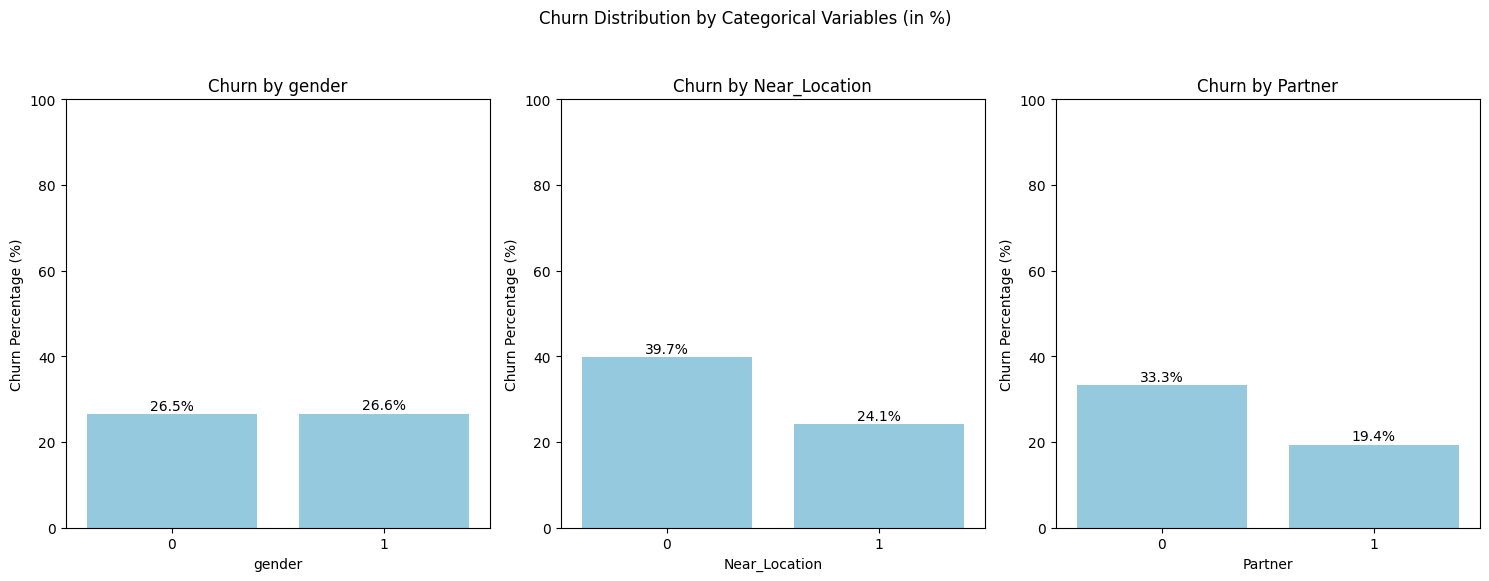

In [7]:
categorical_vars = ['gender', 'Near_Location', 'Partner']
plot_categorical_churn(df, categorical_vars)

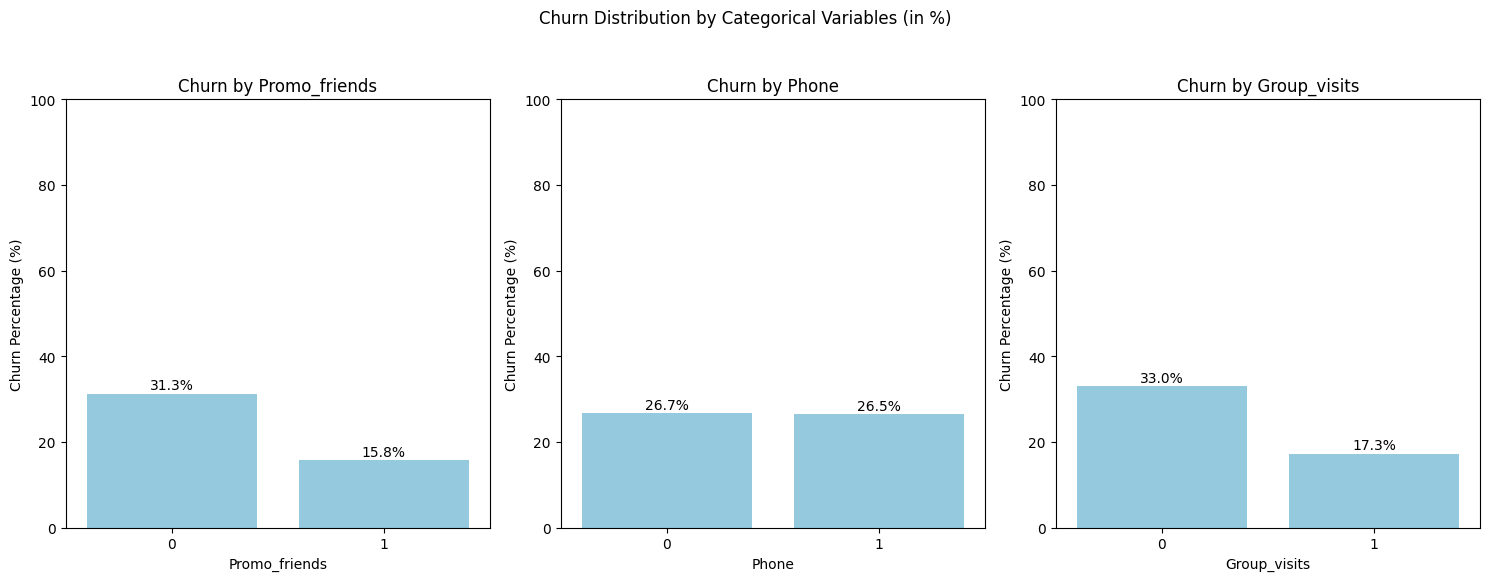

In [8]:
categorical_vars = ['Promo_friends', 'Phone', 'Group_visits']
plot_categorical_churn(df, categorical_vars)

##**Categorical Variables Impact on Churn**

The analysis of binary categorical variables reveals important patterns:

* **Gender**: There appears to be a slight difference in churn rates between genders that warrants further investigation

* **Location Proximity**: Customers living near the gym likely have significantly lower churn rates

* **Partnership Status**: Having a partner may correlate with lower churn

* **Promotional Friends:** Those who came through friend promotions might show different churn behavior

* **Phone Usage:** How customers interact via phone may impact their retention

* **Group Visits**: Participation in group classes probably reduces churn compared to individual workouts

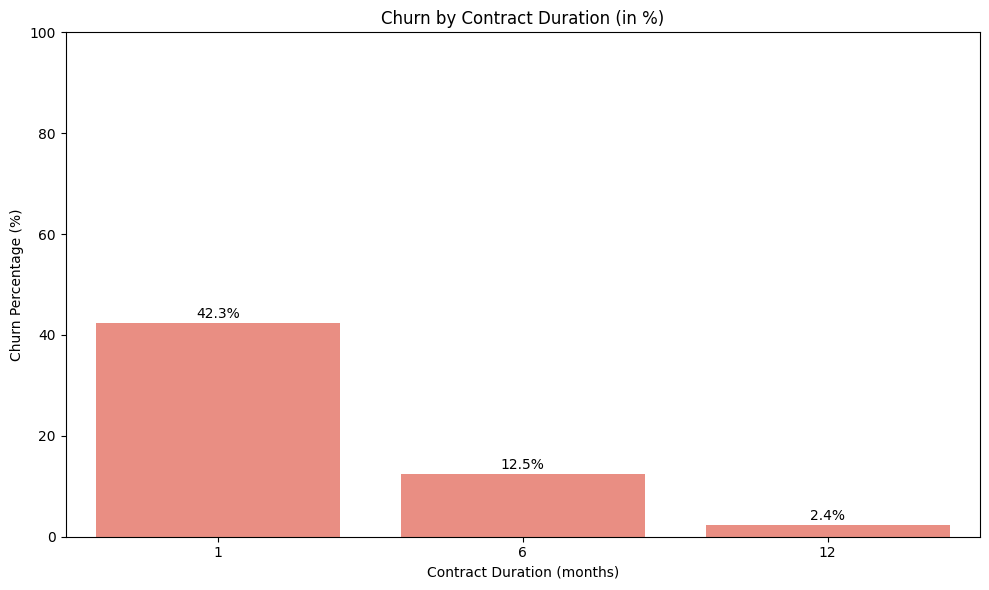

In [9]:
plot_contract_period_churn(df)

## **Contract Duration Matters**
* Shorter contract periods (especially 1-month contracts) show substantially higher churn rates

* Longer contracts (6-12 months) demonstrate better customer retention

* This suggests commitment length is a strong predictor of retention

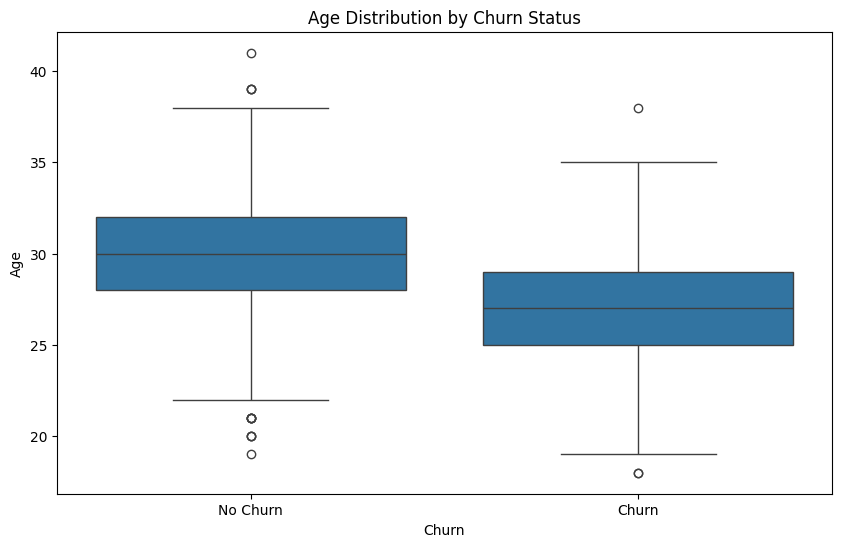

In [10]:
plot_age_distribution(df)

## **Age Distribution**
* Younger members tend to churn more frequently than older members

* The age range of loyal customers is likely more concentrated in specific brackets

* This could inform targeted retention strategies for different age groups



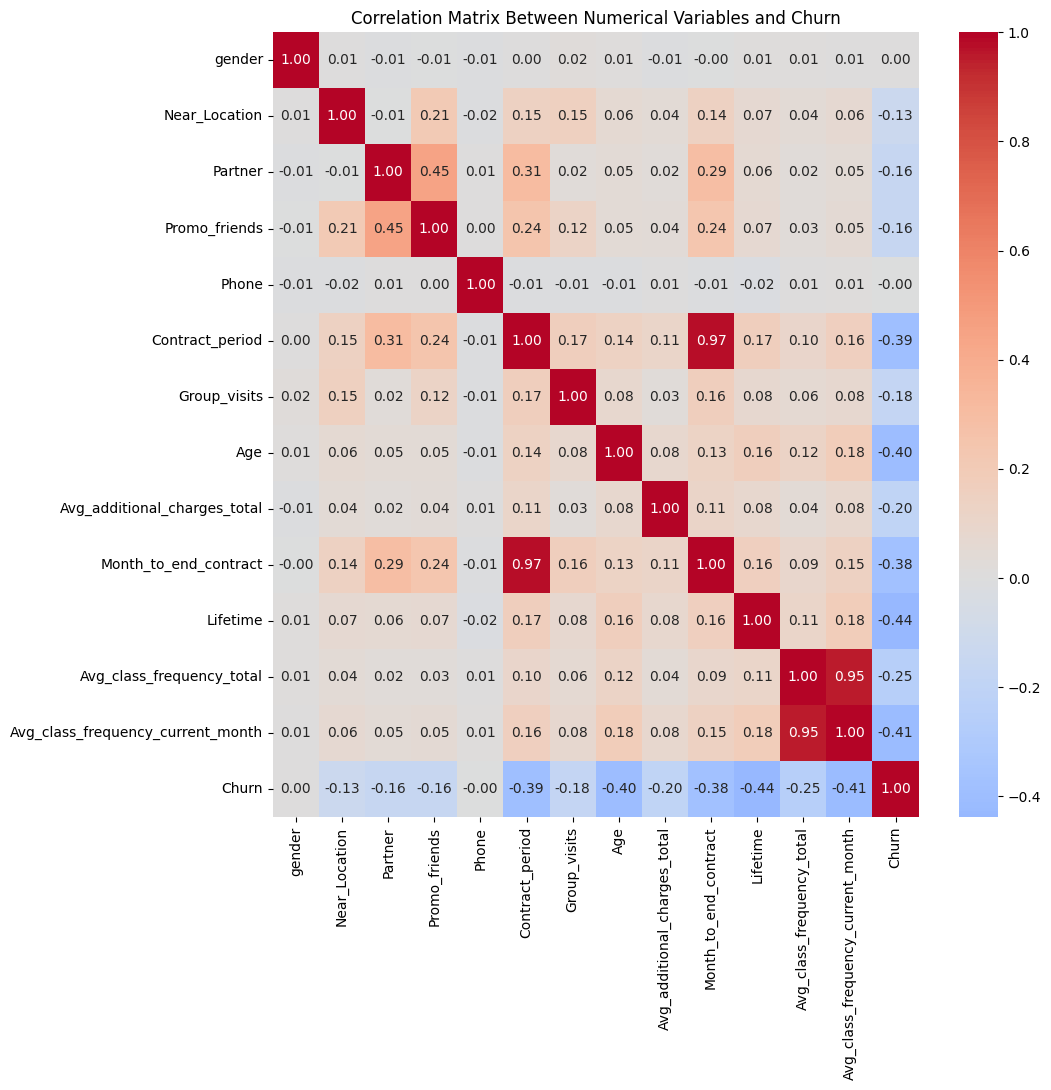

In [11]:
plot_correlation_matrix(df, df.corr(), figsize=(11, 11))

Gender and phone have no correlation with churn;

"contract_period" and "month_to_end_contract" have an almost perfect correlation, as one is the inverse of the other;

"avg_class_frequency_current_month" and "avg_class_frequency_total" show an almost perfect correlation, which may indicate that gym attendance patterns do not change significantly over time;

"near_location", "partner", "promo_friends", and "group_visits" have a low correlation with churn;

"promo_friends" and "partner" have a high correlation.

## **Correlation Insights**
* The correlation matrix would show which behavioral metrics are most strongly associated with churn

* There are likely interesting relationships between usage frequency metrics and other variables

## **Recommended Actions:**
* Target short-term contract members with retention offers as their contracts near expiration

* Promote group classes to increase social engagement and reduce churn

* Develop loyalty programs for younger members who are higher churn risks

* Monitor usage patterns to identify at-risk customers based on attendance drops

* Consider incentives for customers who don't live near the gym to improve their retention

* The data suggests that both contractual factors (like commitment length) and behavioral factors (like usage frequency) are important predictors of churn, and that a multi-faceted retention strategy would be most effective.

#**Aprofundamento da Análise das correlações**
Agora farei a visualização da correlação das colunas:

'month_to_end_contract' e 'contract_period',
'avg_class_frequency_current_month' e 'avg_class_frequency_total'

In [16]:
gym_churn.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


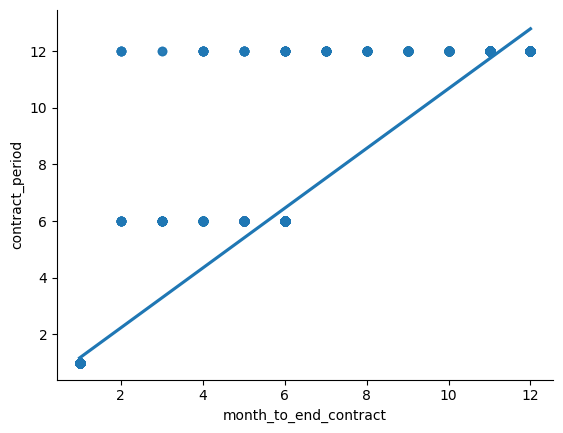

In [17]:
# Create a scatter plot with a regression line
sns.regplot(x='month_to_end_contract', y='contract_period', data=gym_churn)

sns.despine()

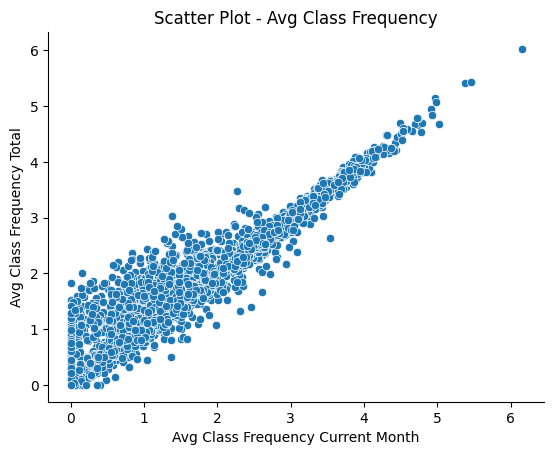

In [18]:
# Create a scatter plot
sns.scatterplot(x='avg_class_frequency_current_month', y='avg_class_frequency_total', data=gym_churn)
sns.despine()

plt.title('Scatter Plot - Avg Class Frequency')
plt.xlabel('Avg Class Frequency Current Month')
plt.ylabel('Avg Class Frequency Total')
plt.show()

## Customer Churn Prediction Model  

### Building a model to predict customer churn  

#### Creating functions:

In [20]:
def print_all_metrics(y_true, y_pred, y_proba, title='Classification metrics'):
    # Print metrics title
    print(title)

    # Calculate and print accuracy
    print('\tAccuracy: {}'.format(accuracy_score(y_true, y_pred)))

    # Calculate and print precision
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))

    # Calculate and print recall (sensitivity)
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))

    # Calculate and print F1 score
    print('\tF1: {:.2f}'.format(f1_score(y_true, y_pred)))

    # Calculate and print ROC AUC score
    print('\tROC_AUC: {}'.format(roc_auc_score(y_true, y_proba)))

In [21]:
def save_all_metrics(y_true, y_pred, y_proba, df, name='Name of the Model'):
    # Create an empty list to store metrics
    metrics = []

    # Get the variable name containing the DataFrame 'df'
    variable_name = [name for name, value in globals().items() if value is df][0]

    # Calculate and store metrics in a list
    metrics = [variable_name,  # DataFrame variable name
               name,           # Model name
               accuracy_score(y_true, y_pred),    # Accuracy
               precision_score(y_true, y_pred),   # Precision
               recall_score(y_true, y_pred),     # Recall (sensitivity)
               f1_score(y_true, y_pred),          # F1 Score
               roc_auc_score(y_true, y_proba) ]   # ROC AUC Score

    return metrics

In [23]:
def reg_class(df, y_col, fet=False):
    metrics = []  # List to store metrics

    # Split data into features (X matrix) and target variable (y)
    X = df.drop(y_col, axis=1)
    y = df[y_col]

    # Split data into train and test sets, with 20% for testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    # Train StandardScaler on the training set
    scaler = StandardScaler()
    scaler.fit(X_train)

    # Transform both train and test sets
    X_train_st = scaler.transform(X_train)
    X_test_st = scaler.transform(X_test)

    # Define the logistic regression model algorithm
    lr_model = LogisticRegression(random_state=0, penalty='l2', C=1.0)

    # Train the logistic regression model
    lr_model.fit(X_train_st, y_train)

    # Use the trained model to make predictions
    lr_predictions = lr_model.predict(X_test_st)
    lr_probabilities = lr_model.predict_proba(X_test_st)[:, 1]

    # Calculate and store metrics for logistic regression
    metrics.append(save_all_metrics(y_test, lr_predictions, lr_probabilities, df, 'LogisticRegression'))

    # Define the random forest model algorithm
    rf_model = RandomForestClassifier(n_estimators=100, random_state=0)

    # Train the random forest model
    rf_model.fit(X_train_st, y_train)

    # Use the trained model to make predictions
    rf_predictions = rf_model.predict(X_test_st)
    rf_probabilities = rf_model.predict_proba(X_test_st)[:, 1]

    # Calculate and store metrics for random forest
    metrics.append(save_all_metrics(y_test, rf_predictions, rf_probabilities, df, 'RandomForestClassifier'))

    importances = rf_model.feature_importances_

    if fet:
        return importances
    else:
        return metrics

In [24]:
# Remove columns not relevant for analysis
gym_churn_1 = gym_churn.drop(['gender', 'phone'], axis=1)

# Continue removing non-relevant columns
gym_churn_2 = gym_churn.drop(['gender', 'phone', 'near_location'], axis=1)

# Remove more columns to simplify analysis
gym_churn_3 = gym_churn.drop(['gender', 'phone', 'near_location', 'partner'], axis=1)

# Remove partnership and referral-related columns
gym_churn_4 = gym_churn.drop(['gender', 'phone', 'near_location', 'partner', 'promo_friends'], axis=1)

# Remove group participation columns
gym_churn_5 = gym_churn.drop(['gender', 'phone', 'near_location', 'partner', 'promo_friends', 'group_visits'], axis=1)

# Remove additional charges-related columns
gym_churn_6 = gym_churn.drop(['gender', 'phone', 'near_location', 'partner', 'promo_friends',
                              'group_visits', 'avg_additional_charges_total'], axis=1)

# Remove class frequency-related column
gym_churn_7 = gym_churn.drop(['gender', 'phone', 'near_location', 'partner', 'promo_friends',
                              'group_visits', 'avg_additional_charges_total', 'avg_class_frequency_total'], axis=1)


# The columns contract_period and month_to_end_contract are highly correlated, we'll create a model for each

# Remove contract_period column
gym_churn_8 = gym_churn.drop(['gender', 'phone', 'near_location', 'partner', 'promo_friends',
                              'contract_period'], axis=1)

# Remove month_to_end_contract column
gym_churn_9 = gym_churn.drop(['gender', 'phone', 'near_location', 'partner', 'promo_friends',
                               'month_to_end_contract'], axis=1)


# Alternative model
gym_churn_10 = gym_churn.drop(['gender', 'phone', 'contract_period', 'partner', 'promo_friends'], axis=1)

# Alternative model
gym_churn_11 = gym_churn.drop(['gender', 'phone', 'near_location', 'partner', 'promo_friends', 'contract_period'], axis=1)

# Alternative model
gym_churn_12 = gym_churn.drop(['gender', 'phone', 'near_location',
                               'partner', 'promo_friends', 'avg_class_frequency_total'], axis=1)

In [25]:
# List to store metrics
metric = []

# Perform logistic regression analysis for each DataFrame with different columns excluded
metric += reg_class(gym_churn, 'churn'),\
        reg_class(gym_churn_1, 'churn'),\
        reg_class(gym_churn_2, 'churn'),\
        reg_class(gym_churn_3, 'churn'),\
        reg_class(gym_churn_4, 'churn'),\
        reg_class(gym_churn_5, 'churn'),\
        reg_class(gym_churn_6, 'churn'),\
        reg_class(gym_churn_7, 'churn'),\
        reg_class(gym_churn_8, 'churn'),\
        reg_class(gym_churn_9, 'churn'),\
        reg_class(gym_churn_10, 'churn'),\
        reg_class(gym_churn_11, 'churn'),\
        reg_class(gym_churn_12, 'churn')

# Column names for the final DataFrame
columns_names = ['dataframe', 'model', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc']

# Create a consolidated DataFrame with all metrics
all_metrics_models = pd.DataFrame(list(chain.from_iterable(metric)), columns=columns_names)

## Selecting the best model
</p>

What the metrics mean:
</p>

- **Accuracy:** Measures the proportion of correct predictions made by the model out of all predictions.</p>

- **Precision:** Measures the proportion of correct positive predictions (true positives) out of all positive predictions (true positives + false positives).</p>

- **Recall (Sensitivity):** Measures the model's ability to correctly identify positive cases out of all actual positive cases.</p>

- **F1-Score:** A metric that combines both precision and recall into a single score.</p>

- **AUC-ROC (Area Under the ROC Curve):** The ROC (Receiver Operating Characteristic) curve is a graphical representation of the model's ability to distinguish between positive and negative classes.</p>

In [27]:
# Sort the DataFrame by metrics and apply a color gradient style
all_metrics_models\
        .sort_values(by=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'], ascending=False)\
        .style.background_gradient()

,dataframe,model,accuracy,precision,recall,f1,roc_auc
9,gym_churn_4,RandomForestClassifier,0.932500,0.867347,0.858586,0.862944,0.973615
10,gym_churn_5,LogisticRegression,0.928750,0.873016,0.833333,0.852713,0.969781
7,gym_churn_3,RandomForestClassifier,0.928750,0.869110,0.838384,0.853470,0.973049
17,gym_churn_8,RandomForestClassifier,0.928750,0.865285,0.843434,0.854220,0.974978
23,gym_churn_11,RandomForestClassifier,0.928750,0.865285,0.843434,0.854220,0.974978
21,gym_churn_10,RandomForestClassifier,0.926250,0.867725,0.828283,0.847545,0.973883
8,gym_churn_4,LogisticRegression,0.925000,0.863158,0.828283,0.845361,0.971224
18,gym_churn_9,LogisticRegression,0.925000,0.863158,0.828283,0.845361,0.971215
16,gym_churn_8,LogisticRegression,0.925000,0.863158,0.828283,0.845361,0.970981
22,gym_churn_11,LogisticRegression,0.925000,0.863158,0.828283,0.845361,0.970981


In [28]:
# Sorts the DataFrame by metrics and highlights the maximum value in each numeric column
all_metrics_models\
        .sort_values(by=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'], ascending=False)\
        .style.highlight_max()

,dataframe,model,accuracy,precision,recall,f1,roc_auc
9,gym_churn_4,RandomForestClassifier,0.932500,0.867347,0.858586,0.862944,0.973615
10,gym_churn_5,LogisticRegression,0.928750,0.873016,0.833333,0.852713,0.969781
7,gym_churn_3,RandomForestClassifier,0.928750,0.869110,0.838384,0.853470,0.973049
17,gym_churn_8,RandomForestClassifier,0.928750,0.865285,0.843434,0.854220,0.974978
23,gym_churn_11,RandomForestClassifier,0.928750,0.865285,0.843434,0.854220,0.974978
21,gym_churn_10,RandomForestClassifier,0.926250,0.867725,0.828283,0.847545,0.973883
8,gym_churn_4,LogisticRegression,0.925000,0.863158,0.828283,0.845361,0.971224
18,gym_churn_9,LogisticRegression,0.925000,0.863158,0.828283,0.845361,0.971215
16,gym_churn_8,LogisticRegression,0.925000,0.863158,0.828283,0.845361,0.970981
22,gym_churn_11,LogisticRegression,0.925000,0.863158,0.828283,0.845361,0.970981


The best model for predicting churn was from dataframe **gym_churn_4**, which contains the following variables:

- contract_period  
- group_visits  
- age  
- avg_additional_charges_total  
- month_to_end_contract  
- lifetime  
- avg_class_frequency_total  
- avg_class_frequency_current_month  

It was the best model for accuracy, recall and f1 score.

## **Analysis of the best model**

In [31]:
# Define best model as gym_churn_4
best_model = gym_churn_4

# Visualization of the best model
best_model.head()

,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [32]:
# Calculate feature importances using the 'reg_class' function
importances = reg_class(best_model, 'churn', True)

# Reshape the 'importances' array to have a single row
importances = importances.reshape(1, -1)

# Get column names from 'best_model' DataFrame excluding the 'churn' column
columns_names = list(best_model.drop(['churn'], axis=1).columns)

# Create a 'porc_imp' DataFrame with feature importances, using original feature names as column names
porc_imp = pd.DataFrame(importances, columns=columns_names).T.reset_index()

# Rename column 0 to 'percentage of importance'
porc_imp = porc_imp.rename(columns={0: 'percentage of importance'}).sort_values(by='percentage of importance', ascending=False)

# Apply a color gradient style to the DataFrame to highlight importances
porc_imp.style.background_gradient()

,index,percentage of importance
5,lifetime,0.273345
7,avg_class_frequency_current_month,0.200310
6,avg_class_frequency_total,0.147191
2,age,0.124562
3,avg_additional_charges_total,0.098716
0,contract_period,0.072082
4,month_to_end_contract,0.068574
1,group_visits,0.015220


To identify potential churn, focus on:

- **Lifetime**: Number of months the user has been attending the gym  
- **Monthly visit frequency**: How often the user goes to the gym per month  
- **User age**: The member's current age  

The higher the values of these variables, the lower the probability of churn.

## Creating customer groups

I will use a dendrogram to visualize the optimal number of clusters (users with similar characteristics). Then, I will apply the K-means unsupervised machine learning algorithm to assign the groups based on the number determined by the dendrogram.

### Construction of the dendrogram to visualize the number of groups


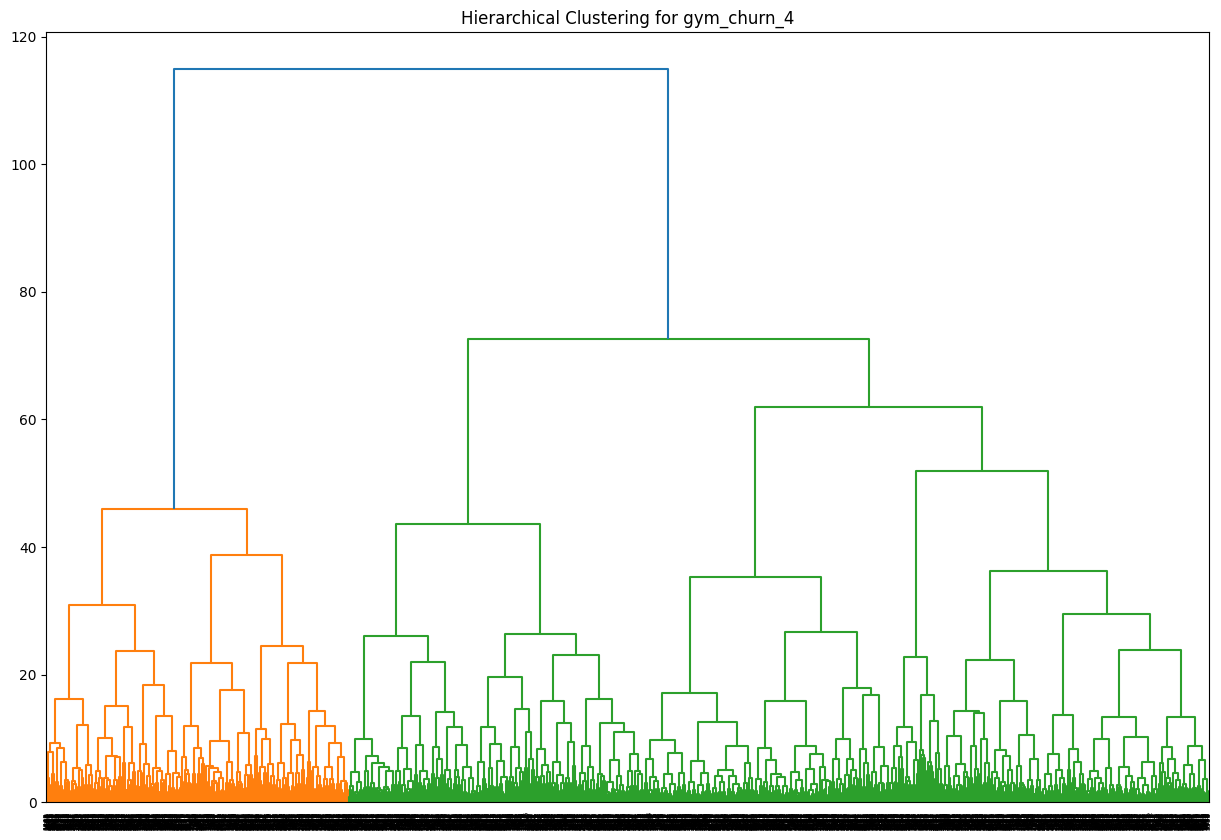

In [34]:
# Separate predictor variables (X) and target variable (y)
X = best_model.drop('churn', axis=1)  # X contains all columns except 'churn'
y = best_model['churn']              # y contains only the 'churn' column

# Create a StandardScaler object to standardize (scale) the predictor variables
scaler = StandardScaler()

# Apply standardization (scaling) to the data in X and store result in X_st
X_st = scaler.fit_transform(X)

# Calculate linkage hierarchy using Ward's method
linked = linkage(X_st, method='ward')

# Create a plot figure with specific size
plt.figure(figsize=(15, 10))

# Plot dendrogram based on the calculated linkage hierarchy
dendrogram(linked, orientation='top')

# Set dendrogram title
plt.title('Hierarchical Clustering for gym_churn_4')

# Display the dendrogram
plt.show()

- The optimal number of clusters is 2;

- I will perform a 2-cluster grouping on the best model dataframe;

- I will also create a 5-cluster grouping to compare the differences.

### Creating groups with Kmeans, with 2 and 5 groups

In [36]:
# Create a KMeans object with 5 clusters
km_5 = KMeans(n_clusters=5)

# Create a KMeans object with 2 clusters
km_2 = KMeans(n_clusters=2)

# Apply KMeans algorithm with 5 clusters to X_st data and assign cluster labels
labels_5 = km_5.fit_predict(X_st)

# Apply KMeans algorithm with 2 clusters to X_st data and assign cluster labels
labels_2 = km_2.fit_predict(X_st)

# Add 'group_5' and 'group_2' columns to best_model DataFrame to store cluster labels
best_model['group_5'] = labels_5
best_model['group_2'] = labels_2

In [37]:
# Dataframe Visualization
best_model.head()

,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn,group_5,group_2
0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0,4,1
1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0,3,0
2,1,0,28,129.448479,1.0,2,1.859098,1.736502,0,0,1
3,12,1,33,62.669863,12.0,2,3.205633,3.357215,0,3,0
4,1,0,26,198.362265,1.0,3,1.113884,1.120078,0,0,1


### Análise das características dos grupos

In [38]:
# Calculate the mean of 'churn' column for each group in 'group_5' and display results
media_churn_group_5 = best_model.groupby('group_5')['churn'].mean()

# Display the mean churn values for each group based on 'group_5'
display(media_churn_group_5)

# Calculate the mean of 'churn' column for each group in 'group_2' and display results
media_churn_group_2 = best_model.groupby('group_2')['churn'].mean()

# Display the mean churn values for each group based on 'group_2'
display(media_churn_group_2)

,churn
group_5,
0,0.673623
1,0.151399
2,0.118857
3,0.012456
4,0.041451


,churn
group_2,
0,0.021030
1,0.393743


In [39]:
# Groups the 'best_model' DataFrame by 'group_5' values, calculates column means for each group, and sorts results in descending order based on 'churn'
resultados_group_5 = best_model.groupby('group_5').mean().sort_values(by='churn', ascending=False)

# Displays the mean results for each group created based on 'group_5'
display(resultados_group_5)

# Groups the 'best_model' DataFrame by 'group_2' values, calculates column means for each group, and sorts results in descending order based on 'churn'
resultados_group_2 = best_model.groupby('group_2').mean().sort_values(by='churn', ascending=False)

# Displays the mean results for each group created based on 'group_2'
display(resultados_group_2)

,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn,group_2
group_5,,,,,,,,,,
0,1.621870,0.190317,27.415693,121.948189,1.554257,1.826377,1.140133,0.827024,0.673623,1.000000
1,2.536896,1.000000,29.996183,152.518900,2.361323,4.264631,2.245884,2.192556,0.151399,0.741730
2,2.514286,0.000000,29.954286,154.033357,2.398857,4.622857,2.547353,2.526625,0.118857,0.802286
4,10.352332,0.552677,29.946459,166.812072,9.554404,4.685665,1.000059,0.985259,0.041451,0.238342
3,11.733096,0.560498,29.834520,160.921261,10.572954,4.628114,2.805990,2.798614,0.012456,0.000000


,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn,group_5
group_2,,,,,,,,,,
1,1.806944,0.337657,28.765738,137.132787,1.723388,3.084319,1.700107,1.530827,0.393743,0.968714
0,10.144307,0.554025,29.979695,165.590918,9.263234,4.941987,2.219070,2.216033,0.021030,2.899927


- Creating boxplot function

In [40]:
def box_groups(group, title_1, title_2):
    # Create a plot figure with specific dimensions
    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot a boxplot using Seaborn for 'lifetime' grouped by clusters and colored by 'churn'
    sns.boxplot(x=group, y='lifetime', hue='churn', data=best_model, ax=ax)

    # Set the plot title
    plt.title(title_1)

    # Set x-axis tick label size
    plt.xticks(fontsize=12)

    # Create another plot figure with specific dimensions
    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot a boxplot using Seaborn for 'avg_class_frequency_current_month' grouped by clusters and colored by 'churn'
    sns.boxplot(x=group, y='avg_class_frequency_current_month', hue='churn', data=best_model, ax=ax)

    # Set x-axis tick label size
    plt.xticks(fontsize=12)

    # Set the plot title
    plt.title(title_2)

    # Remove plot borders
    sns.despine()
    sns.despine()

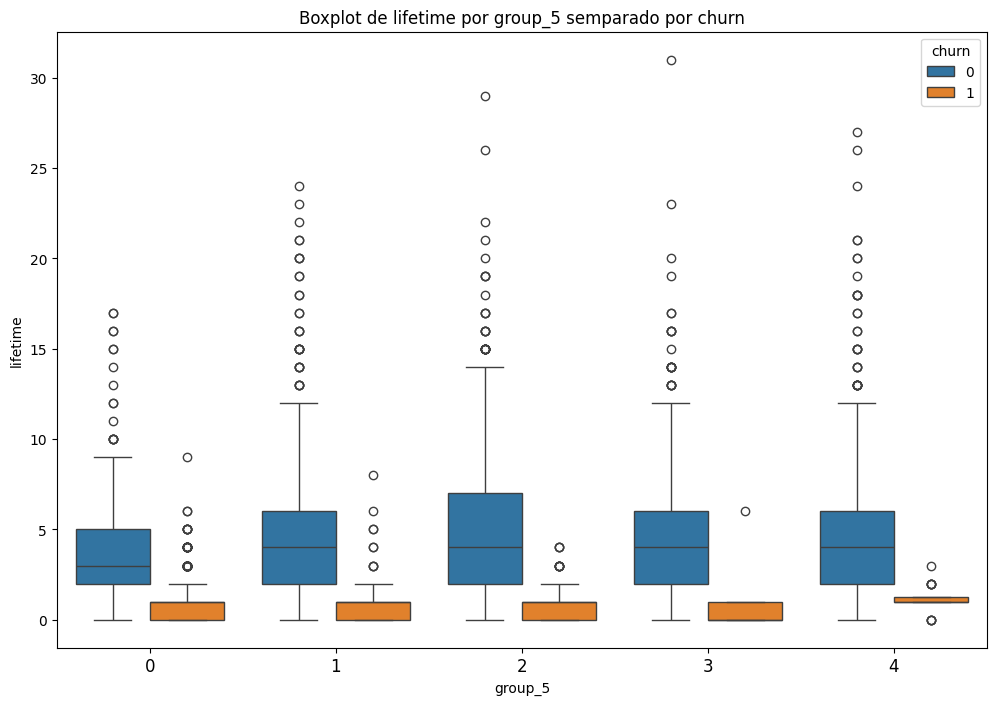

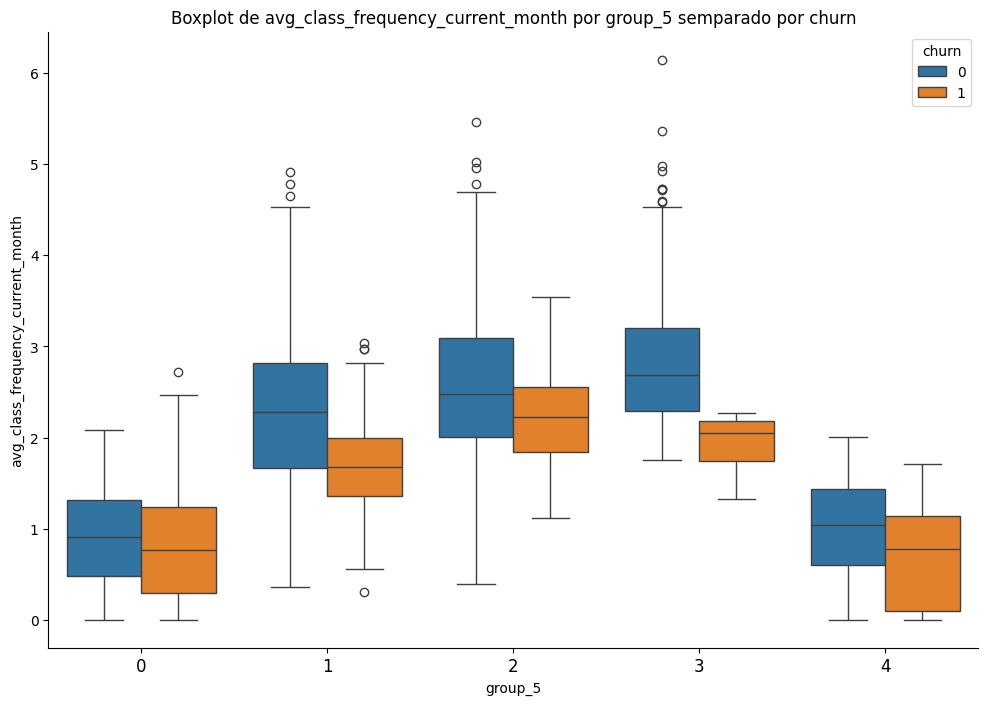

In [42]:
# View lifetime and monthly frequency separated by group_5
box_groups('group_5', 'Boxplot de lifetime por group_5 semparado por churn',\
           'Boxplot de avg_class_frequency_current_month por group_5 semparado por churn')

- We can identify that in almost all groups, churns occur in a lifetime of less than 3 months.
- With groups 2 and 4 having the highest chance of churn, the departure of these groups is at a monthly frequency of less than twice a week.

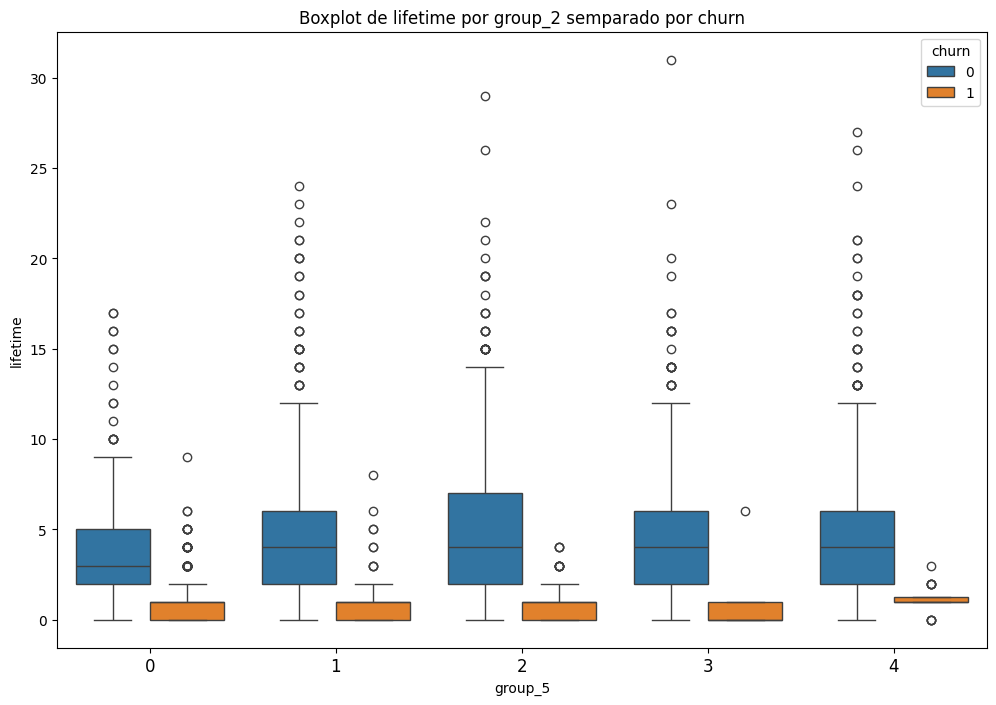

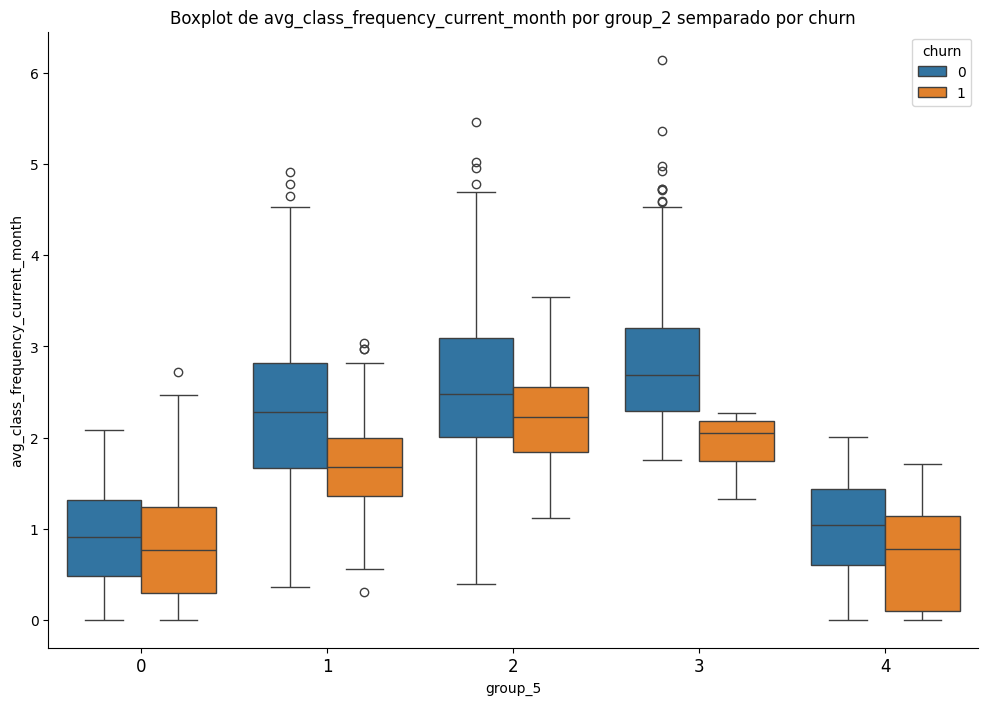

In [44]:
# View lifetime and monthly frequency separated by group_2
box_groups('group_5', 'Boxplot de lifetime por group_2 semparado por churn',\
           'Boxplot de avg_class_frequency_current_month por group_2 semparado por churn')

- The cluster analysis visualization reveals consistent patterns:
- After 3 months of gym membership, churn probability drops dramatically
- Active members maintain a frequency of 2+ weekly visits

- Characteristics of high-churn-risk groups (ordered by relevance):
  - Less than 3 months of gym membership
  - Below 1.5 weekly visits on average
  - Age under 29 years
  - 1-month contract duration

- Key traits of loyal members (ordered by relevance):
  - More than 3 months of membership
  - 2+ weekly visits on average
  - With these traits, churn likelihood becomes minimal

## Conclusion
### Key User Characteristics:
- Users with less than 3 months of gym attendance and weekly frequency below 1.5 visits are more likely to churn

- Users with more than 3 months of gym attendance and weekly frequency above 2 visits are less likely to churn

- Users under 29 years old are more likely to churn

### Recommendations:
- Develop psychological or economic incentives (discounts or rewards) for users who maintain at least 3 months of membership

- Monitor weekly user frequency to identify those who drop below 1.5 visits per week

- Increase marketing focus on members with attendance below 1.5 weekly visits

- Target marketing campaigns at new users over 29 years old, as this group has lower churn probability